# 基于卷积神经网络的手写英文字母识别系统研究

## 准备数据集及数据预处理

### 将下载的数据集按类重命名

In [9]:
"""""
import os
import string

# 定义源目录路径
source_dir = "EnglishImg/EnglishImg/English/Img/GoodImg/Bmp"

# 生成目标文件夹名称列表
target_folders = list(string.digits) + list(string.ascii_uppercase) + [f"{char}_" for char in string.ascii_lowercase]

# 获取源目录下的所有文件夹名称
source_folders = sorted([f for f in os.listdir(source_dir) if os.path.isdir(os.path.join(source_dir, f))])

# 确保源文件夹数量与目标文件夹数量一致
if len(source_folders) != len(target_folders):
    raise ValueError("源文件夹数量与目标文件夹数量不一致")

# 重命名文件夹
for source_folder, target_folder in zip(source_folders, target_folders):
    source_path = os.path.join(source_dir, source_folder)
    target_path = os.path.join(source_dir, target_folder)

    try:
        os.rename(source_path, target_path)
        print(f"重命名: {source_path} -> {target_path}")
    except FileExistsError:
        print(f"目标文件夹 {target_path} 已存在，跳过重命名 {source_path}")
    except Exception as e:
        print(f"重命名 {source_path} 到 {target_path} 时出错: {e}")
"""""




'""\nimport os\nimport string\n\n# 定义源目录路径\nsource_dir = "EnglishImg/EnglishImg/English/Img/GoodImg/Bmp"\n\n# 生成目标文件夹名称列表\ntarget_folders = list(string.digits) + list(string.ascii_uppercase) + [f"{char}_" for char in string.ascii_lowercase]\n\n# 获取源目录下的所有文件夹名称\nsource_folders = sorted([f for f in os.listdir(source_dir) if os.path.isdir(os.path.join(source_dir, f))])\n\n# 确保源文件夹数量与目标文件夹数量一致\nif len(source_folders) != len(target_folders):\n    raise ValueError("源文件夹数量与目标文件夹数量不一致")\n\n# 重命名文件夹\nfor source_folder, target_folder in zip(source_folders, target_folders):\n    source_path = os.path.join(source_dir, source_folder)\n    target_path = os.path.join(source_dir, target_folder)\n\n    try:\n        os.rename(source_path, target_path)\n        print(f"重命名: {source_path} -> {target_path}")\n    except FileExistsError:\n        print(f"目标文件夹 {target_path} 已存在，跳过重命名 {source_path}")\n    except Exception as e:\n        print(f"重命名 {source_path} 到 {target_path} 时出错: {e}")\n'

### 划分训练集和测试集

In [10]:
import torch
import torch.nn as nn
from torchvision.datasets import ImageFolder
import torchvision.models as models
from torchvision import utils
import torchvision.transforms as T
import torch.utils.data as Data
from PIL import Image
import numpy as np
import torch.optim as optim
import os
import matplotlib.pyplot as plt
#使用tensorboardX进行可视化
from tensorboardX import SummaryWriter
from torchvision import datasets
from torch.utils.data import random_split, DataLoader
EPOCH = 2
BATCH_SIZE = 128
LR = 1e-4

In [11]:
# 定义数据预处理变换
transform = T.Compose([
    T.Grayscale(num_output_channels=1),
    T.ToTensor(),
    # 如果需要标准化，可以取消注释以下行
    # T.Normalize([0.5], [0.5])
])
# 定义划分数据集的函数
def split_dataset(root_dir, transform, train_ratio=0.7, val_ratio=0.15, test_ratio=0.15, batch_size=128, shuffle=True, random_seed=42):
    """
    划分数据集为训练集、验证集和测试集，并返回对应的DataLoader。

    参数:
    - root_dir: 数据集根目录
    - transform: 数据预处理变换
    - train_ratio: 训练集比例
    - val_ratio: 验证集比例
    - test_ratio: 测试集比例
    - batch_size: 批次大小
    - shuffle: 是否打乱数据
    - random_seed: 随机种子，用于保证结果可重复

    返回:
    - train_loader: 训练集DataLoader
    - val_loader: 验证集DataLoader
    - test_loader: 测试集DataLoader
    - full_dataset: 原始的ImageFolder数据集
    """
    # 确保比例之和为1
    assert train_ratio + val_ratio + test_ratio == 1, "比例之和必须为1"

    # 加载整个数据集
    full_dataset = datasets.ImageFolder(root=root_dir, transform=transform)

    # 计算每个子集的大小
    dataset_size = len(full_dataset)
    train_size = int(train_ratio * dataset_size)
    val_size = int(val_ratio * dataset_size)
    test_size = dataset_size - train_size - val_size

    # 随机划分数据集
    train_dataset, val_dataset, test_dataset = Data.random_split(full_dataset, [train_size, val_size, test_size], generator=torch.Generator().manual_seed(random_seed))

    # 创建DataLoader
    train_loader = Data.DataLoader(train_dataset, batch_size=batch_size, shuffle=shuffle)
    val_loader = Data.DataLoader(val_dataset, batch_size=batch_size, shuffle=shuffle)
    test_loader = Data.DataLoader(test_dataset, batch_size=batch_size, shuffle=shuffle)

    return train_loader, val_loader, test_loader, full_dataset



训练集大小: 5393
验证集大小: 1155
测试集大小: 1157


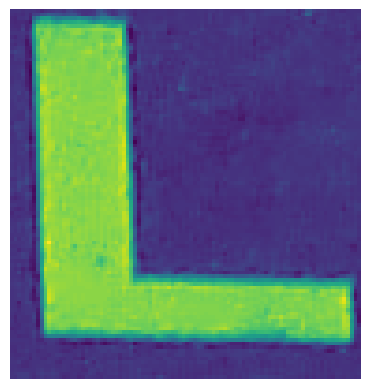

CNN(
  (Conv1): Sequential(
    (0): Conv2d(1, 16, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (Conv2): Sequential(
    (0): Conv2d(16, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): Dropout(p=0.2, inplace=False)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (Linear): Sequential(
    (0): Linear(in_features=1568, out_features=400, bias=True)
    (1): Dropout(p=0.2, inplace=False)
    (2): ReLU()
    (3): Linear(in_features=400, out_features=80, bias=True)
    (4): ReLU()
    (5): Linear(in_features=80, out_features=62, bias=True)
  )
)


In [16]:
# 使用函数划分数据集
train_loader, val_loader, test_loader, full_dataset = split_dataset(
    root_dir="EnglishImg/EnglishImg/English/Img/GoodImg/Bmp",
    transform=transform,
    train_ratio=0.7,
    val_ratio=0.15,
    test_ratio=0.15,
    batch_size=BATCH_SIZE,
    shuffle=True,
    random_seed=42
)

# 打印数据集大小
print(f"训练集大小: {len(train_loader.dataset)}")
print(f"验证集大小: {len(val_loader.dataset)}")
print(f"测试集大小: {len(test_loader.dataset)}")

# 获取类别数量
label_num = len(full_dataset.class_to_idx)

# 数据可视化
to_img = T.ToPILImage()
a = to_img(train_loader.dataset[0][0])  # size=[1, 28, 28]
plt.imshow(a)
plt.axis('off')
plt.show()

# 定义CNN模型
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.Conv1 = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=16, kernel_size=5, stride=1, padding=2),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        self.Conv2 = nn.Sequential(
            nn.Conv2d(16, 32, 5, 1, 2),
            nn.Dropout(p=0.2),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        self.Linear = nn.Sequential(
            nn.Linear(32*7*7, 400),
            nn.Dropout(p=0.2),
            nn.ReLU(),
            nn.Linear(400, 80),
            nn.ReLU(),
            nn.Linear(80, label_num),
        )

    def forward(self, input):
        input = self.Conv1(input)
        input = self.Conv2(input)
        input = input.view(input.size(0), -1)
        output = self.Linear(input)
        return output

cnn = CNN()
print(cnn)

# 定义优化器
optimizer = torch.optim.Adam(cnn.parameters(), lr=LR)
# 定义损失函数
loss_func = nn.CrossEntropyLoss()

CNN(
  (Conv1): Sequential(
    (0): Conv2d(1, 16, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (Conv2): Sequential(
    (0): Conv2d(16, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): Dropout(p=0.2, inplace=False)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (Linear): Sequential(
    (0): Linear(in_features=1568, out_features=400, bias=True)
    (1): Dropout(p=0.2, inplace=False)
    (2): ReLU()
    (3): Linear(in_features=400, out_features=80, bias=True)
    (4): ReLU()
    (5): Linear(in_features=80, out_features=62, bias=True)
  )
)
